In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
!export SM_FRAMEWORK=tf.keras

In [13]:
!pip install segmentation_models

In [14]:
# !pip install -U -q segmentation-models
# !pip install -q tensorflow
# !pip install -q keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [15]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [16]:
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
import segmentation_models as sm

In [31]:
import glob
import cv2
import os
images_t = glob.glob("DRIVE/training/images/*.tif")
images_t.sort()
images_v = glob.glob("DRIVE/test/images/*.tif")
images_v.sort()
masks_t = glob.glob("DRIVE/training/1st_manual/*.gif")
masks_t.sort()
masks_v = glob.glob("DRIVE/test/1st_manual/*.gif")
masks_v.sort()
print(len(images_t))
print(len(images_v))
print(len(masks_t))
print(len(masks_v))

20
20
20
20


In [36]:
#pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [37]:
import imageio
import numpy as np
img = imageio.imread('DRIVE/test/1st_manual/01_manual1.gif')
array = np.asarray(img) # convert to numpy array if needed

<class 'numpy.ndarray'>
(584, 565)
<class 'numpy.ndarray'>


/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_30454/482809347.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('DRIVE/test/1st_manual/01_manual1.gif')


/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_30454/3790427717.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(y)
/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_30454/3790427717.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(y)


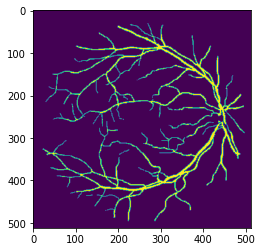

In [55]:
import imageio
import numpy as np
import os
image_t=[]
image_v=[]
mask_t=[]
mask_v=[]
for x in images_t:
  im=cv2.imread(x,cv2.IMREAD_COLOR)
  im=cv2.resize(im,(512,512))
  image_t.append(im)
for x in images_v:
  im=cv2.imread(x,cv2.IMREAD_COLOR)
  im=cv2.resize(im,(512,512))
  image_v.append(im)
for y in masks_t:
  img = imageio.imread(y)
  ma=np.asarray(img)[...,np.newaxis] # convert to numpy array if needed
  ma=cv2.resize(ma,(512,512),interpolation = cv2.INTER_NEAREST)
  plt.imshow(ma)
  mask_t.append(ma/255.0)
for y in masks_v:
  img = imageio.imread(y)
  ma=np.asarray(img)[...,np.newaxis] # convert to numpy array if needed
  ma=cv2.resize(ma,(512,512),interpolation = cv2.INTER_NEAREST)
  plt.imshow(ma)
  mask_v.append(ma/255.0)

In [56]:
print(len(image_t),len(mask_t))
img_array_t=np.array(image_t)
mask_array_t=np.array(mask_t)
mask_array_t=np.expand_dims(mask_array_t,axis=-1)
img_array_v=np.array(image_v)
mask_array_v=np.array(mask_v)
mask_array_v=np.expand_dims(mask_array_v,axis=-1)
mask_array_t=mask_array_t.astype(np.float32)
mask_array_v=mask_array_v.astype(np.float32)
print(img_array_t.shape)
print(mask_array_t.shape)
print((np.unique(mask_array_t)))
print(mask_array_t.shape)

20 20
(20, 512, 512, 3)
(20, 512, 512, 1)
[0. 1.]
(20, 512, 512, 1)


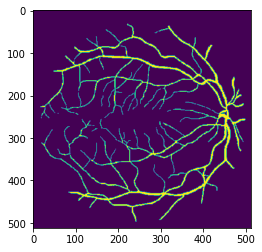

In [57]:
plt.imshow(mask_array_t[19])

In [58]:
#img_array_t[0]
np.max(mask_array_t[0])

1.0

In [79]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb4'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, input_shape=(512,512,3),encoder_weights='imagenet',activation='sigmoid')
# plot_model(model)

In [80]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics = ['binary_accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.IOUScore(),sm.metrics.FScore()])

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('checkpoints/',save_best_only=True,monitor='val_iou_score',mode='max')
lrp=ReduceLROnPlateau(monitor="iou_score", factor=0.1, patience=5)
es=EarlyStopping(patience=6,monitor='iou_score')
call=[lrp, mp, es]
history=model.fit(img_array_t, 
          mask_array_t,
          batch_size=1, 
          epochs=20,
          validation_data=(img_array_v, mask_array_v),callbacks=call)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.7388 - binary_accuracy: 0.5351 - recall_6: 0.8837 - precision_6: 0.1437 - auc_6: 0.8357 - iou_score: 0.1145 - f1-score: 0.2051

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


20/20 [==============================] - 71s 3s/step - loss: 0.7388 - binary_accuracy: 0.5351 - recall_6: 0.8837 - precision_6: 0.1437 - auc_6: 0.8357 - iou_score: 0.1145 - f1-score: 0.2051 - val_loss: 19.6398 - val_binary_accuracy: 0.4766 - val_recall_6: 0.5849 - val_precision_6: 0.0951 - val_auc_6: 0.5235 - val_iou_score: 0.0866 - val_f1-score: 0.1592 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 38s 2s/step - loss: 0.3919 - binary_accuracy: 0.9454 - recall_6: 0.7527 - precision_6: 0.6616 - auc_6: 0.9283 - iou_score: 0.1635 - f1-score: 0.2803 - val_loss: 2.3182 - val_binary_accuracy: 0.7423 - val_recall_6: 0.2366 - val_precision_6: 0.0979 - val_auc_6: 0.4616 - val_iou_score: 0.0611 - val_f1-score: 0.1106 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.2334 - binary_accuracy: 0.9581 - recall_6: 0.7128 - precision_6: 0.7826 - auc_6: 0.9512 - iou_score: 0.2310 - f1-score: 0.3740

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


20/20 [==============================] - 57s 3s/step - loss: 0.2334 - binary_accuracy: 0.9581 - recall_6: 0.7128 - precision_6: 0.7826 - auc_6: 0.9512 - iou_score: 0.2310 - f1-score: 0.3740 - val_loss: 0.5708 - val_binary_accuracy: 0.8605 - val_recall_6: 0.5275 - val_precision_6: 0.3200 - val_auc_6: 0.6637 - val_iou_score: 0.1500 - val_f1-score: 0.2575 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.1623 - binary_accuracy: 0.9612 - recall_6: 0.7218 - precision_6: 0.8088 - auc_6: 0.9644 - iou_score: 0.3130 - f1-score: 0.4759

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


20/20 [==============================] - 57s 3s/step - loss: 0.1623 - binary_accuracy: 0.9612 - recall_6: 0.7218 - precision_6: 0.8088 - auc_6: 0.9644 - iou_score: 0.3130 - f1-score: 0.4759 - val_loss: 0.4113 - val_binary_accuracy: 0.8878 - val_recall_6: 0.7625 - val_precision_6: 0.4220 - val_auc_6: 0.8572 - val_iou_score: 0.2454 - val_f1-score: 0.3930 - lr: 0.0010
Epoch 5/20
20/20 [==============================] - ETA: 0s - loss: 0.1293 - binary_accuracy: 0.9629 - recall_6: 0.7340 - precision_6: 0.8180 - auc_6: 0.9698 - iou_score: 0.3821 - f1-score: 0.5524

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


20/20 [==============================] - 56s 3s/step - loss: 0.1293 - binary_accuracy: 0.9629 - recall_6: 0.7340 - precision_6: 0.8180 - auc_6: 0.9698 - iou_score: 0.3821 - f1-score: 0.5524 - val_loss: 0.2826 - val_binary_accuracy: 0.9252 - val_recall_6: 0.8403 - val_precision_6: 0.5475 - val_auc_6: 0.9484 - val_iou_score: 0.2852 - val_f1-score: 0.4431 - lr: 0.0010
Epoch 6/20
20/20 [==============================] - ETA: 0s - loss: 0.1141 - binary_accuracy: 0.9637 - recall_6: 0.7339 - precision_6: 0.8265 - auc_6: 0.9727 - iou_score: 0.4235 - f1-score: 0.5944

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


20/20 [==============================] - 56s 3s/step - loss: 0.1141 - binary_accuracy: 0.9637 - recall_6: 0.7339 - precision_6: 0.8265 - auc_6: 0.9727 - iou_score: 0.4235 - f1-score: 0.5944 - val_loss: 0.2442 - val_binary_accuracy: 0.9306 - val_recall_6: 0.8728 - val_precision_6: 0.5675 - val_auc_6: 0.9621 - val_iou_score: 0.3221 - val_f1-score: 0.4866 - lr: 0.0010
Epoch 7/20
20/20 [==============================] - ETA: 0s - loss: 0.1057 - binary_accuracy: 0.9652 - recall_6: 0.7539 - precision_6: 0.8276 - auc_6: 0.9772 - iou_score: 0.4498 - f1-score: 0.6202

INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


20/20 [==============================] - 64s 3s/step - loss: 0.1057 - binary_accuracy: 0.9652 - recall_6: 0.7539 - precision_6: 0.8276 - auc_6: 0.9772 - iou_score: 0.4498 - f1-score: 0.6202 - val_loss: 0.1853 - val_binary_accuracy: 0.9459 - val_recall_6: 0.8412 - val_precision_6: 0.6470 - val_auc_6: 0.9603 - val_iou_score: 0.3481 - val_f1-score: 0.5160 - lr: 1.0000e-04


In [84]:
model.save('final-model')

INFO:tensorflow:Assets written to: final-model/assets


INFO:tensorflow:Assets written to: final-model/assets


1/1 [==============================] - 6s 6s/step


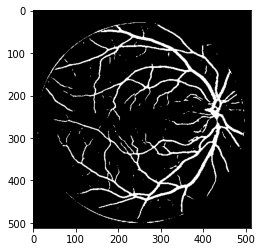

In [83]:
test_preds = model.predict(img_array_v)
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
test_img = preds_test_thresh[5, :, :, 0]
plt.imshow(test_img, cmap='gray')

In [ ]:
len(history.history['val_loss'])
total_epoch = len(history.history['val_loss'])

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,total_epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history['binary_accuracy']
loss_val = history.history['val_binary_accuracy']
epochs = range(1,total_epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
for i in range(0,len(img_array_v)):
    plt.figure(figsize=(15,15))
    plt.axis('Off')
    test_image = img_array_v[i, :, :, 0]
    plt.subplot(1,3,1)
    plt.imshow(test_image)
    plt.title('Input Image', fontsize=14)
    plt.axis('off')

    test_mask=mask_array_v[i,:,:]
    plt.subplot(1,3,2)
    plt.imshow(test_mask)
    plt.title('Ground Truth Mask')
    plt.axis('off')

    test_mask = preds_test_thresh[i, :, :, 0]
    plt.subplot(1,3,3)
    plt.imshow(test_mask, cmap='gray')
    plt.title('Pred Mask', fontsize=14)
    plt.axis('off')

In [ ]:
sz = len(history.history['val_loss'])
print("Training Scores:")
print("Precision:",history.history['precision'][sz-1])
print("Recall:",history.history['recall'][sz-1])
print("iou_score:",history.history['iou_score'][sz-1])
print("f1-score:",history.history['f1-score'][sz-1])

print("")
print("Validation Scores:")
print("Precision:",history.history['val_precision'][sz-1])
print("Recall:",history.history['val_recall'][sz-1])
print("iou_score:",history.history['val_iou_score'][sz-1])
print("f1-score:",history.history['val_f1-score'][sz-1])